This notebook uses the thickness_sim library to show the falicy of measuring a single line of thickness points across the net to determine thickness range.  This is assuming the predominant cause of thickness variation is the slots in the die.

The cell below loads thickness_sim, imports libraries, and creates an instance of the net model.

In [24]:
import thickness_sim
from math import pi
from numpy import linspace

net = thickness_sim.NetModel()

In [25]:
net.create_net(100,100,pi/4,pi/4,40,2,.03)

In [26]:
net.print_net_stats()

Width = 40.00 Length = 80.00 Target Thickness = 0.030
Number of knots: 40301
Number of slots in inside die: 100
Number of slots in outside die: 100
Net is symmetrical, angle = 90.0 deg.
Thickness average of all knots = 0.0300
Thickness max = 0.0300, min = 0.0300, range = 0.0000


The cell below adds the variation in the inside and outside die directions.

In [27]:
net.indie_variator(1,.001)
net.outdie_variator(1,.001)

Below is a plot of the variation added.

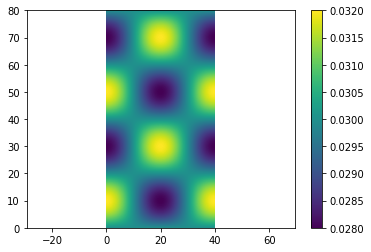

In [28]:
net.plot_2d_contour()

The cell below puts a line of 10 probe points across the web 10" from start.  This appears to cross where there is a high range.

In [29]:
net.add_probe_line_across(10)

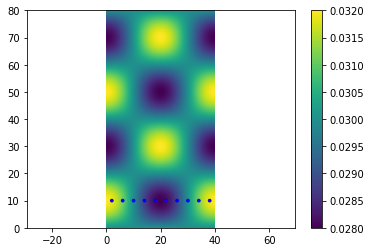

In [30]:
net.plot_2d_contour()

Below executes the measurements then prints the stats.

In [31]:
net.execute_probe()
net.print_probe_stats()


Number of samples = 10
Average thickness = 0.0301
Max thickness = 0.0319
Min thickness = 0.0281
Thickness range = 0.0038




The probe point below is at 19" which looks to be a point that will give a low range. 


Number of samples = 10
Average thickness = 0.0301
Max thickness = 0.0304
Min thickness = 0.0298
Thickness range = 0.0006




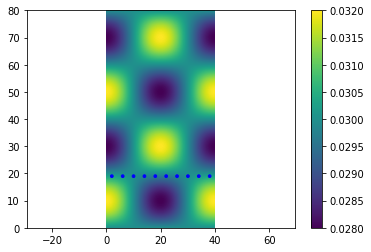

In [32]:
net.clear_probe_pts()
net.add_probe_line_across(19)
net.execute_probe()
net.plot_2d_contour()
net.print_probe_stats()

In [33]:
dps = [] 
for y in linspace(0, 22, 50):
    net.clear_probe_pts()
    net.add_probe_line_across(y)
    net.execute_probe()
    dps.append((y, net.avg_probe_thkns(), net.thkns_range_probe()))
# for dp in dps:
#     print('y={:5.2f} avg={:6.4f} thkns={:6.4f}'.format(*dp))

The cell below graphs the thickness range from 0 to 22 inches up from bottom.  You can see that most measurements are well below the known true peak of .004.

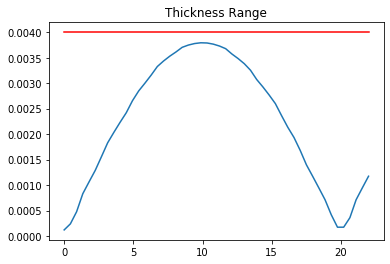

In [35]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('tkAgg')

plt.figure()
x = [x[0] for x in dps]
y_range = [x[2] for x in dps]
plt.title('Thickness Range')
plt.plot(x, y_range)
plt.plot([0, 22], [.004, .004], color='r')

The average is plotted below.  It is much more stable than the range.

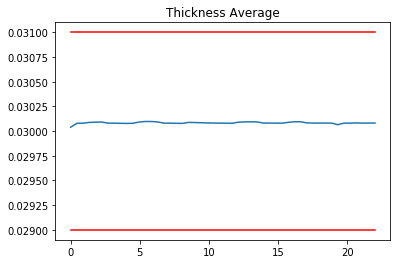

In [36]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('tkAgg')

plt.figure()
x = [x[0] for x in dps]
y_avg = [x[1] for x in dps]
plt.title('Thickness Average')
plt.plot(x,y_avg)
plt.plot([0, 22], [.029, .029], color='r')
plt.plot([0, 22], [.031, .031], color='r')


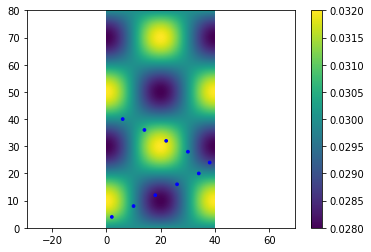

In [40]:
net.clear_probe_pts()
net.add_probe_pts_from_file('probe_pts.csv')
net.plot_2d_contour()

In [42]:
net.execute_probe()
net.print_probe_stats()


Number of samples = 10
Average thickness = 0.0301
Max thickness = 0.0318
Min thickness = 0.0282
Thickness range = 0.0036


